# WaveformReadML

This script performs the following actions:<br>
<ol>
<li>Reads waveforms from LZap file<br>
<li>Handles mutliple dimensions coexisting in a panda dataframe<br>
<li>Selects S1 pulses only<br>
<li>Normalises pulses to unit area<br>
<li>Defines RQs : peak width, peak heights, peak prominence<br>
<li>Defines AFT5 (time at an area of 5% of the total area of the pulse)<br>
<li>Calculates the amplitude-weighted time of each pulse (new RQ)<br>
<li>Defines prompt fraction<br>
<li>Writes panda to a pickle file<br>
</ol>

NOTE: throughout, the x axes are samples --> 1 sample = 10 ns

### Author : Jordan Palmer (jordan.palmer.2014@live.rhul.ac.uk)
#### Waveform reader from Ishan Khurana

In [42]:
import uproot
import numpy as np
import pandas
import matplotlib.pyplot as plt
#import ray
#ray.init(num_cpus=4)
import pandas as pd
from multiprocessing import  Pool
#import coffea

In [43]:
def get_pod_index(args):
    pod_samples = args[column_to_arg['pod_samples']]
    pod_start_times = args[column_to_arg['pod_start_times']] # Args correspond to the column. Second column in data df is pod_start_times
    pulse_start_times = args[column_to_arg['pulse_start_times']] # Third column in data df is pulse_start_times
    
    pod_times = [(j,j+ len(i)*10) for i,j in zip(pod_samples, pod_start_times)]    
    
    pod_index = {}
    new_index = 0
    
    # Match Pulse with Pod containing waveform
    for i,j in enumerate(pulse_start_times):
        pulse_found = False
        while not pulse_found:
            if pod_times[new_index][0]<=j and j<=pod_times[new_index][1]:
                pod_index[i] = (new_index)
                pulse_found=True
            else:
                new_index+=1
    
#     waveform = [pod_samples[i] for i in pod_index.values()]
#     pulse_class =[i.decode("utf-8") for i in pulse_classes]
    
    return pod_index

In [44]:
def get_waveforms(args):
    pod_samples = args[column_to_arg['pod_samples']]
    pod_index = args[column_to_arg['pod_index']]
    pulse_pod_index = args[column_to_arg['pulse_pod_index']]
    pod_samples = [pod_samples[i] for i in pod_index.values()]
    pulse_waveform = [pod[pulse_pod_index[0]:pulse_pod_index[1]] for pod, pulse_pod_index in zip(pod_samples,pulse_pod_index)]
    return pulse_waveform

In [45]:
def pulse_pod_index(args):
    pulse_start_time = args[column_to_arg['pulse_start_times']]
    pulse_end_time = args[column_to_arg['pulse_end_time']]    
    pod_indices = list(args[column_to_arg['pod_index']].values())
    
    pod_start_times= args[column_to_arg['pod_start_times']][pod_indices]
    
    pulse_start_index = (pulse_start_time-pod_start_times)/10
    pulse_end_index = (pulse_end_time-pod_start_times)/10
    
    pulse_start_index = [int(i) for i in pulse_start_index]
    pulse_end_index = [int(i) for i in pulse_end_index]
    
    return np.dstack([pulse_start_index,pulse_end_index])[0]

#### 1. Read in the lzap file with waveforms saved and save all RQs necessary 

In [46]:
%%time 
erornr = 'ER'
file_path = "/global/cfs/cdirs/lz/users/jpalmer/DATA/ERNRwaveforms/ER_output_sum.root"
data_file = uproot.open(file_path)
df = pd.DataFrame()

df['pod_samples'] = data_file['PodWaveforms'][b'summedPodsTPCHG.podSamples'].array()
df['eventID'] = data_file['Events'][b'eventHeader.eventID'].array()
df['pod_start_times'] = data_file['PodWaveforms'][b'summedPodsTPCHG.podStartTime_ns'].array()
df['pulse_end_time'] = data_file['Events'][b'pulsesTPC.pulseEndTime_ns'].array()
df['pulse_start_times'] = data_file['Events'][b'pulsesTPC.pulseStartTime_ns'].array()
df['pulse_s1'] = data_file['Events'][b'pulsesTPC.s1Probability'].array()
df['pulseArea_phd'] = data_file['Events'][b'pulsesTPC.pulseArea_phd'].array()
#df['pulse_ID'] = data_file['Events'][b'pulsesTPC.pulseID'].array()
#df['single_scatter_s1ID'] = data_file['Scatters'][b'ss.s1PulseID'].array()
# The order in which the columns are added is needed for the functions to operate correctly. 
column_to_arg = {
    'pod_samples':0,
    'eventID':1,
    'pod_start_times':2,
    'pulse_end_time':3,
    'pulse_start_times':4,
    'pulse_s1':5,
    'pulseArea_phd':6,
    #'pulse_ID':7,
    #'single_scatter_s1ID':8,
    'pod_index':7,
    'pulse_pod_index':8,
    'pulse_waveform':9
}

df['pod_index'] = df.apply(get_pod_index, axis =1)
df['pulse_pod_index'] = df.apply(pulse_pod_index,axis = 1)
df['pulse_waveform'] = df.apply(get_waveforms, axis =1)

CPU times: user 4min 2s, sys: 39 s, total: 4min 41s
Wall time: 5min 8s


##### This cell just gives each row a second index. This number corresponds to the waveform viewer "event"

In [47]:
#df = df[0:500]
index_original =[]
for i in range(df.shape[0]):
    index_original.append(i)
df['index_original'] = index_original
print(df.shape[0])

500


#### 2. Deal with multiple dimensions
#### this enables me to perform pulse-level cuts

In [48]:
%%time
#cut = df['pulseArea_phd'] > 5
from pandas.api.types import is_object_dtype

_explodable_types = (tuple, list, np.ndarray)

def explode(df):
    """
    Based on this answer:
    https://stackoverflow.com/questions/12680754/split-explode-pandas\
    -dataframe-string-entry-to-separate-rows/40449726#40449726
    
    Also inside FAST-LZ (fast carpenter) CREDIT : Ben Krikler
    """
    # get the list columns
    lst_cols = [col for col, dtype in df.dtypes.items() if is_object_dtype(dtype)]
    # Be more specific about which objects are ok
    lst_cols = [col for col in lst_cols if isinstance(df[col][0], _explodable_types)]
    if not lst_cols:
        return df

    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # check all lists have same length
    lens = pd.DataFrame({col: df[col].str.len() for col in lst_cols})
    print(lens)
    different_length = (lens.nunique(axis=1) > 1).any()
    if different_length:
        raise ValueError("Cannot bin multiple arrays with different jaggedness")
    lens = lens[lst_cols[0]]
    
    # create "exploded" DF
    flattened = {col: df.loc[lens > 0, col].values for col in lst_cols}
    flattened = {col: sum(map(list, vals), []) for col, vals in flattened.items()}
    res = pd.DataFrame({col: np.repeat(df[col].values, lens) for col in idx_cols})
    res = res.assign(**flattened)

    # Check that rows are fully "exploded"
    return res #to explode > 1 time, return explode(res)

#drop the pod samples and start times (not currently being used from now on)



CPU times: user 0 ns, sys: 132 µs, total: 132 µs
Wall time: 146 µs


##### Drop all columns you dont need, this part can take some time

In [49]:
%%time
df_drop = df.drop(['pod_samples', 'pod_start_times','eventID'], axis=1)
#P = Pool(processes=20)
#result = P.map_async(explode, df_drop)
df_explode = explode(df_drop) #sort out dimensionality in order to perform pulse level cuts

     pulse_end_time  pulse_start_times  pulse_s1  pulseArea_phd  \
0                66                 66        66             66   
1                69                 69        69             69   
2                64                 64        64             64   
3                87                 87        87             87   
4                58                 58        58             58   
..              ...                ...       ...            ...   
495              81                 81        81             81   
496              88                 88        88             88   
497              78                 78        78             78   
498              80                 80        80             80   
499              74                 74        74             74   

     pulse_pod_index  pulse_waveform  
0                 66              66  
1                 69              69  
2                 64              64  
3                 87              87  


##### Reset the index every time a cut has been made so you can easily loop over the dataframe

In [50]:

df_explode= df_explode.reset_index(drop=True)
pulseareacut = df_explode['pulseArea_phd'] > 40 
pulseareacutupper = df_explode['pulseArea_phd'] <50
df_final = df_explode[pulseareacut&pulseareacutupper]

#### 3. Select S1 pulses and first S1
##### OD people can skip this step

In [51]:
 
df_final['pulse_s1']
s1s = df_final['pulse_s1']
df_final = df_final[df_final['pulse_s1']==1]


In [52]:
#df_final = df_final.groupby('index_original').head(1)
df_final

index_original                                          pod_index  \
933                12  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
934                12  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
1359               18  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
2346               31  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 7, 7: ...   
2556               34  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 5, 7: ...   
4960               66  {0: 0, 1: 1, 2: 3, 3: 4, 4: 5, 5: 6, 6: 8, 7: ...   
5247               70  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
5409               72  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 7, 7: ...   
6690               90  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
7711              103  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
7714              103  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
8692              116  {0: 0, 1: 2, 2: 2, 3: 2, 4: 3, 5: 4, 6: 4, 7: ...   
8757              117  {0: 0, 1: 2, 2: 3, 3: 4, 4: 5, 5: 5, 6: 6, 7: ...   
8821              118  {0: 0, 1: 1, 2: 2, 3: 3, 4: 5, 5: 5, 6: 6, 7: ...   
9119              122  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
9306              124  {0: 0, 1: 1, 2: 2, 3: 3, 4: 5, 5: 6, 6: 7, 7: ...   
9739              130  {0: 1, 1: 2, 2: 4, 3: 5, 4: 6, 5: 7, 6: 8, 7: ...   
10584             140  {0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 4, 6: 5, 7: ...   
10950             145  {0: 0, 1: 1, 2: 2, 3: 2, 4: 3, 5: 4, 6: 5, 7: ...   
13952             185  {0: 0, 1: 1, 2: 2, 3: 2, 4: 3, 5: 4, 6: 4, 7: ...   
13953             185  {0: 0, 1: 1, 2: 2, 3: 2, 4: 3, 5: 4, 6: 4, 7: ...   
13969             185  {0: 0, 1: 1, 2: 2, 3: 2, 4: 3, 5: 4, 6: 4, 7: ...   
14267             189  {0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 4, 6: 5, 7: ...   
14487             192  {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: ...   
17704             235  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
18168             241  {0: 0, 1: 1, 2: 2, 3: 4, 4: 5, 5: 6, 6: 7, 7: ...   
18640             247  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
20774             275  {0: 0, 1: 1, 2: 2, 3: 4, 4: 5, 5: 6, 6: 7, 7: ...   
21559             286  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
22928             304  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
24151             320  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
26743             355  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
28090             373  {0: 0, 1: 1, 2: 2, 3: 5, 4: 6, 5: 7, 6: 9, 7: ...   
29282             389  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
30321             403  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
31144             414  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 5, 7: ...   
31617             420  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
32404             431  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
32694             435  {0: 0, 1: 1, 2: 3, 3: 5, 4: 6, 5: 7, 6: 8, 7: ...   
33558             446  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
34082             454  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   
35787             479  {0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 3, 6: 4, 7: ...   
36622             490  {0: 0, 1: 1, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: ...   
37323             499  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...   

       pulse_end_time  pulse_start_times  pulse_s1  pulseArea_phd  \
933            759632             759282       1.0      44.101219   
934            759872             759632       1.0      40.323601   
1359          -495897            -496227       1.0      48.091244   
2346          -153748            -154108       1.0      49.810497   
2556          -476137            -476747       1.0      49.296013   
4960           244102             243792       1.0      46.587830   
5247          -276367            -276667       1.0      42.475868   
5409           562742             

#### 4. Normalise Waveforms to Unit Area
##### This step is important if you dont want the ML algorithm to pick up on the pulse's area. Think about if this is what you want

In [54]:
import numpy as np
from sklearn.preprocessing import normalize

def normalise_array(x):
    x = np.asarray(x)
    norm2 = x / np.sum(x,keepdims=True) 
    return norm2

df_final['pulse_waveform_norm'] = df_final.apply(lambda row : normalise_array(row['pulse_waveform']), axis = 1)
df_final = df_final.reset_index(drop=True)

#### 5. Define RQs like prompt fraction, peak position, peak height, peak width, and peak prominence

In [69]:
%%capture
"""
Defining peak RQs for ML. 
Probably need to tune the threshold 
"""
from scipy.signal import chirp,find_peaks, peak_widths, peak_prominences
import matplotlib.backends.backend_pdf


def find_peaks_(x):
    peaks, _ = find_peaks(x, height=0.02)
    return peaks
def find_peak_heights(x):
    peaks, h = find_peaks(x, height=0.02)
    return h["peak_heights"]
def find_peak_widths(x):
    peaks, h = find_peaks(x, height=0.02)
    widths = peak_widths(x,peaks)
    return widths[0]
def find_peak_prominence(x):
    peaks, h = find_peaks(x, height=0.02)
    prominence = peak_prominences(x, peaks)
    return prominence[0]

peak_positions_ = []
peak_heights_ = []
peak_widths_ = []
peak_prominences_ = []
pulse_area = []
#eventID=[]
original_index2 =[]
for i in range(df_final['pulse_waveform_norm'].shape[0]):
    peak_positions_.append(find_peaks_(df_final['pulse_waveform_norm'][i]))
    peak_heights_.append(find_peak_heights(df_final['pulse_waveform_norm'][i]))
    peak_widths_.append(find_peak_widths(df_final['pulse_waveform_norm'][i]))
    peak_prominences_.append(find_peak_prominence(df_final['pulse_waveform_norm'][i]))
    pulse_area.append(df_final['pulseArea_phd'][i])
    #eventID.append(df_final['eventID'][i])
    original_index2.append(df_final['index_original'][i])

peak_df = pd.DataFrame()
peak_df['peak_heights'] = np.asarray(peak_heights_)
peak_df['peak_positions'] = np.asarray(peak_positions_)
peak_df['peak_prominences'] = np.asarray(peak_prominences_)
peak_df['peak_widths'] = np.asarray(peak_widths_)
peak_df['peak_waveforms'] = np.asarray(df_final['pulse_waveform_norm'])
peak_df['pulseArea_phd'] = np.asarray(pulse_area)
#peak_df['eventID'] = np.array(eventID)
peak_df['original_index'] = np.array(original_index2)
# select waveforms with a reasonable number of peaks and waveforms that dont start too high 
for i in range(peak_df['peak_positions'].shape[0]):
    if (peak_df['peak_positions'][i].shape[0] > 2) | (peak_df['peak_waveforms'][i][0] >= 0.03) | (peak_df['peak_waveforms'][i][peak_df['peak_waveforms'][i].shape[0]-1] >= 0.025):  
        peak_df =peak_df.drop(i)



peak_df= peak_df.reset_index(drop=True)

print(max(peak_df['peak_prominences'][0]))

final_positions = []
final_heights = []
final_widths = []
final_prominances = []
final_waveforms = []
final_areas = []
#final_eventID = []
final_index = []
for i in range(peak_df['peak_prominences'].shape[0]):
    for j in range(peak_df['peak_prominences'][i].shape[0]):
        if peak_df['peak_prominences'][i][j] == max(peak_df['peak_prominences'][i]):
            final_prominances.append(peak_df['peak_prominences'][i][j])
            final_positions.append(peak_df['peak_positions'][i][j])
            final_widths.append(peak_df['peak_widths'][i][j])
            final_heights.append(peak_df['peak_heights'][i][j])
            final_areas.append(peak_df['pulseArea_phd'][i])
            final_waveforms.append(peak_df['peak_waveforms'][i])
            #final_eventID.append(peak_df['eventID'][i])
            final_index.append(peak_df['original_index'][i])

peak_df_f = pd.DataFrame()
peak_df_f['peak_heights'] = np.asarray(final_heights)
peak_df_f['peak_positions'] = np.asarray(final_positions)
peak_df_f['peak_prominences'] = np.asarray(final_prominances)
peak_df_f['peak_widths'] = np.asarray(final_widths)
peak_df_f['pulseArea_phd'] = np.asarray(final_areas)
peak_df_f['peak_waveforms'] = np.asarray(final_waveforms)
#peak_df_f['eventID'] = np.asarray(final_eventID)
peak_df_f['original_index'] = np.asarray(final_index)

#### 6. Finding the 5% AFT

In [70]:
from scipy import integrate

AFT5 = []
for i in range(peak_df['peak_waveforms'].shape[0]):
    AFT5_temp = [] 
    accum = np.cumsum(peak_df['peak_waveforms'][i])
    for j in range(accum.shape[0]):
        if accum[j] >= 0.05:
            AFT5_temp.append(j)
    AFT5.append(AFT5_temp[0])
peak_df_f['AFT5'] = AFT5

peak_df_f['rel_peak_positions'] = peak_df_f['peak_positions'] - peak_df_f['AFT5'] #peak position wrt AFT5
peak_df_f.drop('peak_positions',1)


peak_heights  peak_prominences  peak_widths  pulseArea_phd  \
0       0.099659          0.098423     8.646602      48.091244   
1       0.122228          0.122375     6.151321      49.296013   
2       0.111729          0.111524     8.054766      42.475868   
3       0.133152          0.132538     5.342801      40.258518   
4       0.097293          0.096216     8.848251      49.960060   
5       0.123705          0.123926     6.313617      48.902481   
6       0.097276          0.096113     7.560642      41.071022   
7       0.089728          0.090640    10.455326      43.626244   
8       0.095851          0.094036     8.590531      46.156956   
9       0.092728          0.091765    10.787880      46.410423   
10      0.092680          0.092933     9.126077      42.580509   
11      0.093127          0.088132    10.792001      45.693329   
12      0.093869          0.093479     8.426734      41.705322   
13      0.131917          0.131558     5.973283      43.523258   
14      0.106056          0.106054     8.443444      44.486942   
15      0.080845          0.081135    13.089302      44.059658   
16      0.119660          0.119155     7.786936      48.333630   
17      0.083604          0.081823    11.281554      46.812355   
18      0.098012          0.097849     7.871824      45.778008   
19      0.108502          0.107772     7.880625      41.061916   

                                       peak_waveforms  original_index  AFT5  \
0   [0.00022612499, -0.0006660948, 0.0007669548, 0...              18     5   
1   [0.00047083045, -0.00062164903, 0.00228684, 0....              34     5   
2   [0.00020509287, 0.000597936, 0.0031934998, 0.0...              70     4   
3   [0.00061457977, 0.0011982748, 0.0012176071, 0....              90     5   
4   [-0.00063097995, -0.0014224942, 0.0042280797, ...             116     4   
5   [-0.0022083658, 0.0003584292, 0.0057440056, 0....             117     4   
6   [-9.145886e-05, 0.0006684203, -0.002253611, 0....             118     5   
7   [0.0001237253, -0.0012666304, 0.0033330165, 0....             122     5   
8   [0.001909846, 0.0018146285, 0.0094507225, 0.03...             130     4   
9   [-7.6119504e-05, 0.0011184169, 0.004818009, 0....             145     4   
10  [-4.093767e-05, -0.0006547907, -0.0006060025, ...             192     5   
11  [-0.00062560715, 0.00018771595, 0.0004885696, ...             241     5   
12  [-0.0007341375, 0.002635637, 0.013161622, 0.02...             275     4   
13  [-0.00020190704, 0.001755847, 0.003618282, 0.0...             286     4   
14  [0.0015822871, 0.0013146189, 1.1566547e-06, 0....             320     6   
15  [-0.0015557343, 0.00096902176, 0.008269755, 0....             373     4   
16  [-0.0006367917, -0.0007929543, -0.00018730068,...             414     5   
17  [0.0013703048, 0.0035448049, 0.0058820383, 0.0...             420     4   
18  [-0.00024819988, 0.00061923894, 0.0022864, 0.0...             431     5   
19  [-0.0009128793, 0.0013634696, 0.0023835234, 0....             499     4   

    rel_peak_positions  
0                    2  
1                    3  
2                    4  
3                    3  
4                    4  
5                    2  
6                    4  
7                    2  
8                    3  
9                    4  
10                   3  
11                   3  
12                   4  
13                   2  
14                   6  
15                   5  
16                   2  
17                   3  
18                   4  
19                   5

#### 7. Find the amplitude-weighted average time wrt t0
##### Suggestion from Dan Tovey as a PSD RQ

In [71]:
#(1/(\sum_i a_i))*\sum_i ((t_i-t_0) * a_i)

amp_weighted_time = []

for i in range(peak_df_f['peak_waveforms'].shape[0]): #loop over each waveform
    first_index = peak_df_f['rel_peak_positions'][i] #take the first index to be the peak time
    tot_area = np.sum(peak_df_f['peak_waveforms'][i][first_index:50]) #area from t_0 to t_i 
    amp_weight_sum_tmp = 0
    rolling_area = 0
    for j in range(peak_df_f['peak_waveforms'][i].shape[0]): #loop over waveform i
        if first_index+j >= peak_df_f['peak_waveforms'][i].shape[0]:
            break
        #+= the amp weighted time 
        amp_weight_sum_tmp = amp_weight_sum_tmp + (1/tot_area)*(((first_index+j) - first_index)*peak_df_f['peak_waveforms'][i][first_index+j])

    amp_weighted_time.append(amp_weight_sum_tmp)

    

peak_df_f['amp_weighted_time'] = np.asarray(amp_weighted_time)
peak_df_f


peak_heights  peak_positions  peak_prominences  peak_widths  \
0       0.099659               7          0.098423     8.646602   
1       0.122228               8          0.122375     6.151321   
2       0.111729               8          0.111524     8.054766   
3       0.133152               8          0.132538     5.342801   
4       0.097293               8          0.096216     8.848251   
5       0.123705               6          0.123926     6.313617   
6       0.097276               9          0.096113     7.560642   
7       0.089728               7          0.090640    10.455326   
8       0.095851               7          0.094036     8.590531   
9       0.092728               8          0.091765    10.787880   
10      0.092680               8          0.092933     9.126077   
11      0.093127               8          0.088132    10.792001   
12      0.093869               8          0.093479     8.426734   
13      0.131917               6          0.131558     5.973283   
14      0.106056              12          0.106054     8.443444   
15      0.080845               9          0.081135    13.089302   
16      0.119660               7          0.119155     7.786936   
17      0.083604               7          0.081823    11.281554   
18      0.098012               9          0.097849     7.871824   
19      0.108502               9          0.107772     7.880625   

    pulseArea_phd                                     peak_waveforms  \
0       48.091244  [0.00022612499, -0.0006660948, 0.0007669548, 0...   
1       49.296013  [0.00047083045, -0.00062164903, 0.00228684, 0....   
2       42.475868  [0.00020509287, 0.000597936, 0.0031934998, 0.0...   
3       40.258518  [0.00061457977, 0.0011982748, 0.0012176071, 0....   
4       49.960060  [-0.00063097995, -0.0014224942, 0.0042280797, ...   
5       48.902481  [-0.0022083658, 0.0003584292, 0.0057440056, 0....   
6       41.071022  [-9.145886e-05, 0.0006684203, -0.002253611, 0....   
7       43.626244  [0.0001237253, -0.0012666304, 0.0033330165, 0....   
8       46.156956  [0.001909846, 0.0018146285, 0.0094507225, 0.03...   
9       46.410423  [-7.6119504e-05, 0.0011184169, 0.004818009, 0....   
10      42.580509  [-4.093767e-05, -0.0006547907, -0.0006060025, ...   
11      45.693329  [-0.00062560715, 0.00018771595, 0.0004885696, ...   
12      41.705322  [-0.0007341375, 0.002635637, 0.013161622, 0.02...   
13      43.523258  [-0.00020190704, 0.001755847, 0.003618282, 0.0...   
14      44.486942  [0.0015822871, 0.0013146189, 1.1566547e-06, 0....   
15      44.059658  [-0.0015557343, 0.00096902176, 0.008269755, 0....   
16      48.333630  [-0.0006367917, -0.0007929543, -0.00018730068,...   
17      46.812355  [0.0013703048, 0.0035448049, 0.0058820383, 0.0...   
18      45.778008  [-0.00024819988, 0.00061923894, 0.0022864, 0.0...   
19      41.061916  [-0.0009128793, 0.0013634696, 0.0023835234, 0....   

    original_index  AFT5  rel_peak_positions  amp_weighted_time  
0               18     5                   2           8.715680  
1               34     5                   3           8.559624  
2               70     4                   4           5.909346  
3               90     5                   3           7.418609  
4              116     4                   4           6.222409  
5              117     4                   2           7.163517  
6              118     5                   4           7.606559  
7              122     5                   2           8.901466  
8              130     4                   3           7.203094  
9              145     4                   4           6.573069  
10             192     5                   3           8.763425  
11             241     5                   3           8.486755  
12             275     4                   4           6.841723  
13             286     4                   2           6.859559  
14             320     6                   6           6.378362  
15             373     4   

#### 8. Prompt Fraction Definition
##### OD people will need to change these boundaries

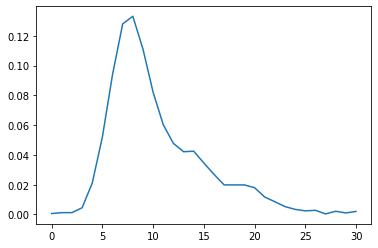

In [72]:
"""
Next, calculate the prompt fraction of each pulse. In LUX, this integral was from -8 ns to 32 ns/−14 to 134 ns.
"""
from scipy import integrate
promptfraction = []
for i in range(peak_df_f['peak_waveforms'].shape[0]):
    #print(np.sum(peak_df['peak_waveforms'][i][0:32]))
    #print(np.sum(peak_df['peak_waveforms'][i][0:150]))    
    lower_lim = peak_df_f['AFT5'][i]
    promptfraction.append((np.sum(peak_df_f['peak_waveforms'][i][lower_lim:lower_lim+12])/np.sum(peak_df_f['peak_waveforms'][i][lower_lim:lower_lim+50])))

peak_df_f['prompt_fraction'] = promptfraction
plt.plot(peak_df['peak_waveforms'][3])

#### 9. Write Panda to Pickle
##### Just because CSV write things as strings and it got annoying 

In [17]:
peak_df_f.to_pickle('/global/project/projectdirs/lz/users/jpalmer/PSD_ML/'+erornr+'rqs.pkl')

##### Show the final s1 waveforms

In [3]:
#for i in range(peak_df_f.shape[0]):
#    plt.plot(peak_df_f['peak_waveforms'][i])
#    print(peak_df_f['peak_waveforms'][i])
#    plt.show()